In [623]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [624]:
def f(x):
    return 3*x**2 - 4*x + 5

In [625]:
f(3.0)

20.0

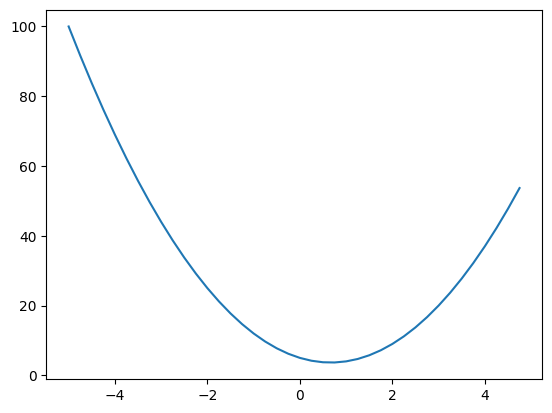

In [626]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys, )

In [627]:
h = 0.00000001
x = 2/3
diff = (f(x + h) - f(x))/h
print("diff =",diff)

diff = 0.0


In [628]:
class value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self.backward = lambda: None
    self.prev = set(_children)
    self.op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data + other.data, (self, other), '+')
    
    def backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out.backward = backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, value) else value(other)
    out = value(self.data * other.data, (self, other), '*')
    
    def backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out.backward = backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = value(self.data**other, (self,), f'**{other}')

    def backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out.backward = backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = max(min(self.data, 20), -20)   # clamp
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = value(t, (self,), 'tanh')

    def backward():
        self.grad += (1 - t**2) * out.grad

    out.backward = backward
    return out

  
  def exp(self):
    x = self.data
    out = value(math.exp(x), (self, ), 'exp')
    
    def backward():
      self.grad += out.data * out.grad
    out.backward = backward
    
    return out
  
  
  def backprop(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node.backward()

In [629]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left→right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        # value node
        dot.node(
            name=uid,
            label="{%s | data %.4f | grad %.4f)}" % (n.label, n.data, n.grad),
            shape='record'
        )

        if n.op:
            # operation node
            op_uid = uid + n.op
            dot.node(name=op_uid, label=n.op)

            # connect op → value
            dot.edge(op_uid, uid)

    for n1, n2 in edges:
        # connect value → op
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)

    return dot


In [630]:

# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [631]:

o.backprop()


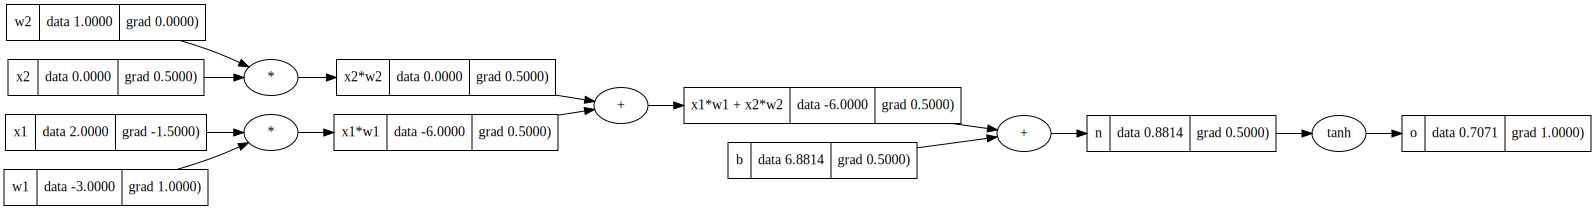

In [632]:

draw_dot(o)

In [728]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in  zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

n = MLP(3, [4, 4, 1])


In [849]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [858]:
for k in range(800):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backprop()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.00030343660735140883
1 0.0003030498895647202
2 0.0003026641500635282
3 0.0003022793851306827
4 0.00030189559106795044
5 0.00030151276419587285
6 0.0003011309008536399
7 0.0003007499973989938
8 0.0003003700502080781
9 0.00029999105567535636
10 0.0002996130102134637
11 0.0002992359102531279
12 0.00029885975224300823
13 0.00029848453264962597
14 0.00029811024795722634
15 0.00029773689466768883
16 0.00029736446930038295
17 0.0002969929683920907
18 0.000296622388496873
19 0.00029625272618598254
20 0.00029588397804775133
21 0.0002955161406874529
22 0.0002951492107272508
23 0.0002947831848060581
24 0.0002944180595794359
25 0.0002940538317194857
26 0.000293690497914774
27 0.0002933280548701971
28 0.00029296649930689767
29 0.0002926058279621706
30 0.0002922460375893342
31 0.0002918871249576726
32 0.00029152908685229826
33 0.0002911719200740777
34 0.0002908156214395225
35 0.0002904601877807204
36 0.00029010561594519397
37 0.0002897519027958445
38 0.00028939904521083505
39 0.00028904704008352

In [859]:
ypred

[value(data=0.9945538126096516),
 value(data=-0.9948164162036662),
 value(data=-0.9927737226637514),
 value(data=0.9935989799052585)]